<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/image_type/inspect_train_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determine confidence threshold for Image Type Classification Models 
---
*Last Updated 29 October 2021*   
Choose which trained model and confidence threshold values to use for classifying EOL images as maps, phylogenies, illustrations, or herbarium sheets. Threshold values should be chosen that maximize coverage and minimize error.

First, choose the 2 best models trained in [image_type_train.ipynb](https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/classification_for_image_tagging/image_type/image_type_preprocessing.ipynb). Then, run this notebook.

Run 500 images per class (map, phylogeny, illustration, herbarium sheet) through the best models chosen in rating_train.ipynb for validation of model performance. Plot histograms of true and false predictions per class at binned confidence intervals to find the best performance by class and confidence threshold. (This is helpful because all models may not learn classes equally well).

Notes:

* Change parameters using form fields on right (/where you see 'TO DO' in code)

***Models were trained in Python 2 and TF 1 in October 2020: MobileNet SSD v2 was trained for 3 hours to 30 epochs with Batch Size=16, Lr=0.00001, Dropout=0.3, epsilon=1e-7, Adam optimizer. Final validation accuracy = 0.90. Inception v3 was trained for 3.5 hours to 30 epochs with Batch Size=16, Lr=0.0001, Dropout=0.2, epsilon=1, Adam optimizer. Final validation accuracy = 0.89.***

## Installs & Imports
---

In [3]:
# Mount google drive to import/export files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# For working with data
import itertools
import os
import numpy as np
import pandas as pd

# For downloading and displaying images
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# For measuring inference time
import time

# For image classification and training
import tensorflow as tf

# Define functions

# To read in EOL formatted data files
def read_datafile(fpath, sep="\t", header=0, disp_head=True, lineterminator='\n', encoding='latin1'):
    """
    Defaults to tab-separated data files with header in row 0
    """
    try:
        df = pd.read_csv(fpath, sep=sep, header=header, lineterminator=lineterminator, encoding=encoding)
        if disp_head:
          print("Data header: \n", df.head())
    except FileNotFoundError as e:
        raise Exception("File not found: Enter the path to your file in form field and re-run").with_traceback(e.__traceback__)
    
    return df

## Run images through for classification and validating predictions (Run 1x for each trained model)   
---
Selected models from rating_train.ipynb   
* Run 11: Inception v3
* Run 13: Mobilenet SSD v2

In [29]:
# Set parameters 

# TO DO: Choose training attempt number to inspect results for
TRAIN_SESS_NUM = "11" #@param ["11", "13"] {allow-input: true}

# Set up directory structure
# TO DO: Type in the path to your working directory in form field to right
wd = "/content/drive/MyDrive/summer20/classification/image_type" #@param {type:"string"}
cwd = wd + '/inspect_resul/'
if not os.path.isdir(cwd):
    os.makedirs(cwd)
%cd $cwd

# Directory to saved models from image_type_train.ipynb
saved_models_dir = wd + '/saved_models/'

# Suppress pandas setting with copy warning
pd.options.mode.chained_assignment = None  # default='warn'

# Define functions

# Define start and stop indices in EOL bundle for running inference   
def set_start_stop(df):
    # To test with a tiny subset, use 5 random bundle images
    N = len(df)
    if test_with_tiny_subset:
        start=np.random.choice(a=N, size=1)[0]
        stop=start+5
    # To run for larger set, use 500 random images
    else: 
        start=np.random.choice(a=N, size=1)[0]
        stop=start+500
    print("\nRunning inference on images")
    
    return start, stop

# Load saved model from directory
def load_saved_model(saved_models_dir, TRAIN_SESS_NUM, module_selection):
    # Load trained model from path
    saved_model_path = saved_models_dir + TRAIN_SESS_NUM
    model = tf.keras.models.load_model(saved_model_path)
    # Get name and image size for model type
    handle_base, pixels = module_selection

    return model, pixels, handle_base

# Get info about model based on training attempt number
def get_model_info(TRAIN_SESS_NUM):
    # Session 11
    if int(TRAIN_SESS_NUM) == 11:
        module_selection = ("inception_v3", 299)
    # Session 13
    elif int(TRAIN_SESS_NUM) == 13:
        module_selection = ("mobilenet_v2_1.0_224", 224)
    dataset_labels = ['herb', 'illus', 'map', 'null', 'phylo'] 

    return module_selection, dataset_labels

# Set filename for saving classification results
def get_test_images(true_imclass):
    inpath = wd + '/pre-processing/images/' + true_imclass
    fns = os.listdir(inpath)
    TEST_IMAGE_PATHS = [os.path.join(inpath, fn) for fn in fns]
    print("\nUsing test images from: \n", inpath)

    return TEST_IMAGE_PATHS

# Set filename for saving classification results
def set_outpath(true_imclass):
    outpath = wd + '/inspect_resul/image_type_' + TRAIN_SESS_NUM + '_' + true_imclass + '.csv'
    print("\nSaving results to: \n", outpath)

    return outpath

# Load in image from file
def image_from_file(im_path):
    imga = Image.open(im_path) # rgba (with transp)
    colormode = imga.getbands()
    img = imga.convert('RGB') # convert to rgb
    image = img.resize([pixels,pixels])
    image = np.reshape(image,[1,pixels,pixels,3])
    image = image*1./255 # normalize colorspace

    return image, colormode

# Get info from predictions to display on images
def get_predict_info(predictions, im_path, im_num, stop, start):
    # Get info from predictions
    label_num = np.argmax(predictions[0], axis=-1)
    conf = predictions[0][label_num]
    im_class = dataset_labels[label_num]
    # Display progress message after each image
    print("Completed for {}, {} of {} files".format(im_path, im_num, format(stop-start, '.0f')))
    
    return label_num, conf, im_class

# Record results for confidence thresholds
# Make placeholder lists to fill for each class
def make_placeholders():
    filenames = []
    confidences = []
    true_imclasses = []
    det_imclasses = []
    colormodes = []

    return filenames, confidences, true_imclasses, det_imclasses, colormodes
    
# Add values for each image to placeholder list
def record_results(fn, conf, true_imclass, det_imclass, colormode):
    filenames.append(fn)
    confidences.append(conf)
    true_imclasses.append(true_imclass)
    det_imclasses.append(det_imclass)
    colormodes.append(colormode)
    results = [filenames, confidences, true_imclasses, det_imclasses, colormodes]

    return results

# Export results
def export_results(results):
    results = pd.DataFrame(results)
    results = results.transpose()
    results.to_csv(outpath, index=False, header=("filename", "confidence", 
                                                     "true_id", "det_id", "colormode"))
    print("Classification predictions for image class {}: {}".format(
          true_imclass, results.head()))
    
# Calculate prediction accuracy
def get_accuracy(obs, all_vals):
    # obs = observed, all_vals = observed + expected
    if obs:
        accuracy = format((obs/all_vals), '.2f')
    else:
        accuracy = 0
    
    return accuracy

/content/drive/MyDrive/summer20/classification/image_type/inspect_resul


In [30]:
# Run inference

# Test with tiny subset (5 images)?
# TO DO: If yes, check test_with_tiny_subset box
test_with_tiny_subset = True #@param {type: "boolean"}

# Load saved model
module_selection, dataset_labels = get_model_info(TRAIN_SESS_NUM)
model, pixels, handle_base = load_saved_model(saved_models_dir, TRAIN_SESS_NUM, module_selection)

# Get test images to run inference on

# Run inference for each image class to compare known versus predicted ratings
true_imclasses = ['herb', 'illus', 'map', 'null', 'phylo']
for true_imclass in true_imclasses:

    # Set filename for saving classification results
    outpath = set_outpath(true_imclass)

    # Make placeholder lists to record values for each image
    filenames, confidences, true_imclasses, det_imclasses, colormodes = make_placeholders()

    # Get test images for running inference
    TEST_IMAGE_PATHS = get_test_images(true_imclass)

    # Run 500 random EOL bundle images through trained model
    start, stop = set_start_stop(TEST_IMAGE_PATHS)
    for im_num, im_path in enumerate(TEST_IMAGE_PATHS[start:stop], start=1):
        try:
            # Read in image from file
            img, colormode = image_from_file(im_path)
        
            # Image classification
            start_time = time.time() # Record inference time
            predictions = model.predict(img, batch_size=1)
            label_num, conf, det_imclass = get_predict_info(predictions, im_path, im_num, stop, start)
            end_time = time.time()
            print("Inference time: {} sec".format(format(end_time-start_time, '.2f')))

            # Record results in placeholder lists to inspect results in next step
            results = record_results(im_path, conf, true_imclass, det_imclass, colormode)

        except:
            pass

    # Combine to df and export results
    export_results(results)


Saving results to: 
 /content/drive/MyDrive/summer20/classification/image_type/inspect_resul/image_type_11_herb.csv

Using test images from: 
 /content/drive/MyDrive/summer20/classification/image_type/pre-processing/images/herb

Running inference on images
Completed for /content/drive/MyDrive/summer20/classification/image_type/pre-processing/images/herb/800px-SH3D21_Phylogenetic_Tree.PNG, 1 of 5 files
Inference time: 1.62 sec
Completed for /content/drive/MyDrive/summer20/classification/image_type/pre-processing/images/herb/Time-calibrated_phylogenetic_tree_for_TMEM255A.png, 2 of 5 files
Inference time: 0.28 sec
Completed for /content/drive/MyDrive/summer20/classification/image_type/pre-processing/images/herb/800px-LOC101055915_Unrooted_Phylogenetic_Tree.png, 3 of 5 files
Inference time: 0.29 sec
Classification predictions for image class herb:                                                    0  ...             4
0  /content/drive/MyDrive/summer20/classification...  ...        (L, A)

In [88]:
# Combine model outputs for image type classes

# Combine prediction files created in codeblock above
imclasses = ['herb', 'illus', 'map', 'null', 'phylo']
base = 'image_type_' + TRAIN_SESS_NUM + '_'
all_filenames = [base + imclass + '.csv' for imclass in imclasses]
all_predictions = pd.concat([pd.read_csv(f, sep=',', header=0, na_filter = False) for f in all_filenames])
print("Model predictions for Training Attempt {}, {}:".format(TRAIN_SESS_NUM, handle_base))
print("No. Images: {}\n{}".format(len(all_predictions), all_predictions[['filename', 'true_id', 'det_id']].head()))

Model predictions for Training Attempt 11, inception_v3:
No. Images: 15
                                            filename true_id det_id
0  /content/drive/MyDrive/summer20/classification...    herb  phylo
1  /content/drive/MyDrive/summer20/classification...    herb  phylo
2  /content/drive/MyDrive/summer20/classification...    herb  phylo
0  /content/drive/MyDrive/summer20/classification...   illus  phylo
1  /content/drive/MyDrive/summer20/classification...   illus  phylo


## Plot prediction error and confidence for each class (Run 1x for each trained model)
---   
Use these histograms to find a confidence threshold value to optimize dataset coverage and accuracy

### Plot histograms

In [89]:
# Define functions

# Valide predictions by image class (and optionally, by: taxon)
def validate_predictions(df, inspect_by_taxon):
    # If inspecting for taxon-specific images only
    taxon = None
    if inspect_by_taxon:
        # TO DO: Type in the taxon you'd like to inspect results for using form field to right
        taxon = "" #@param {type:"string"}
        df = df.loc[df.ancestry.str.contains(taxon, case=False, na=False)]
        print("Inspecting results for {}:\n{}".format(taxon, df.head()))
    
    # Validate predictions
    # Check where true ratings and model-determined classes match
    df['det'] = (df['true_id'] == df['det_id'])
    tru = df.loc[df.det, :] # True ID
    fal = df.loc[~df.det, :] # False ID

    return tru, fal, taxon

# Plot results by image class
def plot_predict_x_conf(tru, fal, thresh, imclasses=imclasses):
    # Break up predictions by image class and confidence values
    # Define variables
    c0,c1,c2,c3,c4 = [imclasses[i] for i in range(0, len(imclasses))]
    # Check how many true/false predictions are at each confidence value
    # Class 0 - 'herb'
    c0t = tru.loc[tru['true_id'] == c0, :] # True dets
    c0f = fal.loc[fal['true_id'] == c0, :] # False dets
    # Class 1 - 'illus'
    c1t = tru.loc[tru['true_id'] == c1, :] 
    c1f = fal.loc[fal['true_id'] == c1, :] 
    # Class 2 - 'map'
    c2t = tru.loc[tru['true_id'] == c2, :] 
    c2f = fal.loc[fal['true_id'] == c2, :] 
    # Class 3 - 'null'
    c3t = tru.loc[tru['true_id'] == c3, :] 
    c3f = fal.loc[fal['true_id'] == c3, :] 
    # Class 4 - 'phylo'
    c4t = tru.loc[tru['true_id'] == c4, :] 
    c4f = fal.loc[fal['true_id'] == c4, :] 

    
    # Plot parameters to make 1 subplot per image class
    kwargs = dict(alpha=0.5, bins=15)
    fig, axes = plt.subplots(len(imclasses), figsize=(10, 10), constrained_layout=True)
    fig.suptitle('Prediction Confidence by Class\n Overall Accuracy: {}'.format(
                  format((len(tru)/(len(tru)+len(fal))),'.2f')))
    
    # Make subplots
    # Class 0 - 'herb'
    # True predictions
    axes[0].hist(c0t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[0].hist(c0f['confidence'], color='r', label='False Det', **kwargs)
    axes[0].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[0], 
                      len(c0t+c0f), format((len(c0t)/(len(c0t)+len(c0f))),'.2f')))
    axes[0].legend();

    # Class 1 - 'illus'
    # True predictions
    axes[1].hist(c1t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[1].hist(c1f['confidence'], color='r', label='False Det', **kwargs)
    axes[1].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[1], 
                      len(c1t+c1f), format((len(c1t)/(len(c1t)+len(c1f))),'.2f')))
    axes[1].legend();

    # Class 2 - 'herb'
    # True predictions
    axes[2].hist(c2t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[2].hist(c2f['confidence'], color='r', label='False Det', **kwargs)
    axes[2].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[2], 
                      len(c2t+c2f), format((len(c2t)/(len(c2t)+len(c2f))),'.2f')))
    axes[2].legend();

    # Class 3 - 'null'
    # True predictions
    axes[3].hist(c3t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[3].hist(c3f['confidence'], color='r', label='False Det', **kwargs)
    axes[3].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[3], 
                      len(c3t+c3f), format((len(c3t)/(len(c3t)+len(c3f))),'.2f')))
    axes[3].legend();

    # Class 4 - 'phylo'
    # True predictions
    axes[4].hist(c4t['confidence'], color='y', label='True Det', **kwargs)
    # False predictions
    axes[4].hist(c4f['confidence'], color='r', label='False Det', **kwargs)
    axes[4].set_title("{} (n={} images)\n Accuracy: {}".format(imclasses[4], 
                      len(c4t+c4f), format((len(c4t)/(len(c4t)+len(c4f))),'.2f')))
    axes[4].legend();

    # Add Y-axis labels
    for ax in fig.get_axes():
        ax.set(ylabel='Freq (# imgs)')
        if thresh:
            ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)

    return fig

# To save the figure
def save_figure(fig, taxon, TRAIN_SESS_NUM=TRAIN_SESS_NUM, handle_base=handle_base):
    # Make filename
    if taxon: # If for a specific taxon
        if 'plant' in taxon:
            handle_base = handle_base + '_plantae'
        elif 'anim' in taxon:
            handle_base = handle_base + '_animalia'

    figname = TRAIN_SESS_NUM + '_' + handle_base + '.png'
    fig.savefig(figname)
    print("Histograms saved to ", figname)

    return figname

Histograms saved to  11_inception_v3.png


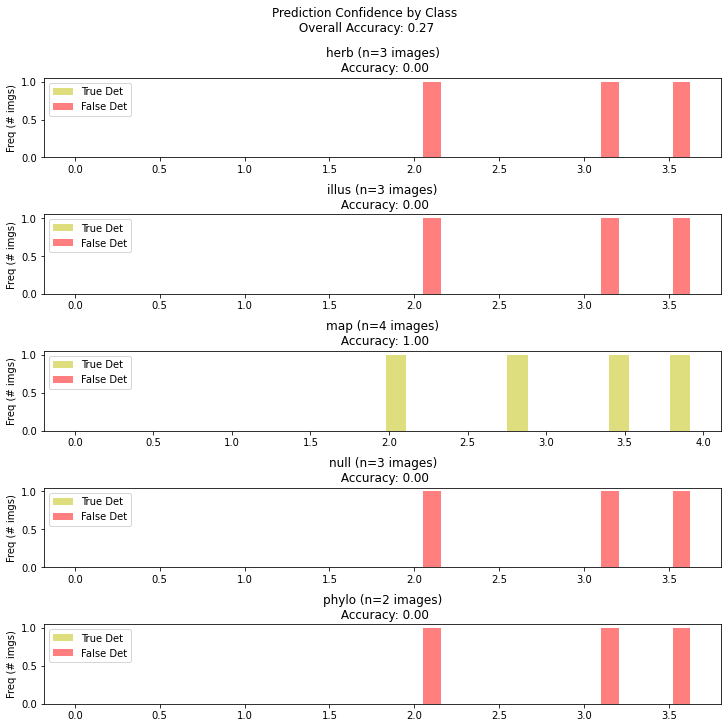

In [90]:
# Load combined prediction results
df = all_predictions.copy()

# Optional: Inspect predictions for taxon-specific images only?
# TO DO: If "yes," check box
inspect_by_taxon = False #@param {type:"boolean"}

# Optional: Draw threshold value to help choose optimal balance b/w maximizing useful data and minimizing error
# TO DO: Set threshold value
thresh = 0 #@param {type:"number"}

# Valide predictions by image class (and optionally, by: taxon)
tru, fal, taxon = validate_predictions(df, inspect_by_taxon)

# Plot results by image class
fig = plot_predict_x_conf(tru, fal, thresh)

# Export histograms
figname = save_figure(fig, taxon)

### Simulate resulting dataset sizes based on different confidence thresholds

In [130]:
# Simple simulation for different confidence values

# Load combined prediction results
df = all_predictions.copy()

# Split by True or False determined image ID
df['det'] = (df["true_id"] == df["det_id"])
tru = df.loc[df.det, :] # True ID
fal = df.loc[~df.det, :] # False ID
 
# Confidence values to test  
# TO DO: Chose range of confidence thresholds based on histograms above
# By confidence value
conf_vals = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2] #@param
for conf_val in conf_vals: 
    df_c = df.loc[df["confidence"] > conf_val, :]
    true_c = tru.loc[tru["confidence"] > conf_val, :]
    fal_c = fal.loc[fal["confidence"] > conf_val, :]
    all_vals = true_c.append(fal_c)
    print("\nConfidence Value: {}\n".format(conf_val))
    print("Accuracy for confidence > {}: {}".format(conf_val, get_accuracy(len(true_c), len(all_vals))))
    print("Predictions Retained (%): {}".format(len(df_c)/len(df)))
    print("True Predictions Retained (%): {}".format(format((len(true_c)/len(tru)), '.2f')))
    print("False Predictions Retained (%): {}".format(format((len(fal_c)/len(fal)), '.2f')))
    print("Accuracy for confidence > {}, by class:".format(conf_val))
    # By class
    for imclass in imclasses:
        true_det_c = len(true_c.loc[true_c["true_id"] == imclass, :])
        all_det_c = len(all_vals.loc[all_vals["true_id"] == imclass, :])
        accuracy = get_accuracy(true_det_c, all_det_c)
        print("{}: {}".format(imclass, accuracy))


Confidence Value: 1.0

Accuracy for confidence > 1.0: 0.27
Predictions Retained (%): 1.0
True Predictions Retained (%): 1.00
False Predictions Retained (%): 1.00
Accuracy for confidence > 1.0, by class:
herb: 0
illus: 0
map: 1.00
null: 0
phylo: 0

Confidence Value: 1.2

Accuracy for confidence > 1.2: 0.27
Predictions Retained (%): 1.0
True Predictions Retained (%): 1.00
False Predictions Retained (%): 1.00
Accuracy for confidence > 1.2, by class:
herb: 0
illus: 0
map: 1.00
null: 0
phylo: 0

Confidence Value: 1.4

Accuracy for confidence > 1.4: 0.27
Predictions Retained (%): 1.0
True Predictions Retained (%): 1.00
False Predictions Retained (%): 1.00
Accuracy for confidence > 1.4, by class:
herb: 0
illus: 0
map: 1.00
null: 0
phylo: 0

Confidence Value: 1.6

Accuracy for confidence > 1.6: 0.27
Predictions Retained (%): 1.0
True Predictions Retained (%): 1.00
False Predictions Retained (%): 1.00
Accuracy for confidence > 1.6, by class:
herb: 0
illus: 0
map: 1.00
null: 0
phylo: 0

Confide

## Inspect detections by image colorspace 
--- 
Noticed that many false dets in illustrations were from greyscale color mode ('L' in pillow). Look at true and false detections for greyscale images in each class

In [136]:
# Break up predictions by image class and colorspace

# Define variables
c0,c1,c2,c3,c4 = [imclasses[i] for i in range(0, len(imclasses))]
# Check how many true/false predictions are at each confidence value
# Class 0 - 'herb'
c0t = tru.loc[tru['true_id'] == c0, :] # True dets
c0f = fal.loc[fal['true_id'] == c0, :] # False dets
# Class 1 - 'illus'
c1t = tru.loc[tru['true_id'] == c1, :] 
c1f = fal.loc[fal['true_id'] == c1, :] 
# Class 2 - 'map'
c2t = tru.loc[tru['true_id'] == c2, :] 
c2f = fal.loc[fal['true_id'] == c2, :] 
# Class 3 - 'null'
c3t = tru.loc[tru['true_id'] == c3, :] 
c3f = fal.loc[fal['true_id'] == c3, :] 
# Class 4 - 'phylo'
c4t = tru.loc[tru['true_id'] == c4, :] 
c4f = fal.loc[fal['true_id'] == c4, :] 

# Class 0 - Herbarium Sheet
print("\n{}".format(c0))
print("False detections: {}\nTrue detections: {}".format(len(c0f), len(c0t)))
f_by_col = c0f.loc[c0f["colormode"]=="('L',)", :]
t_by_col = c0t.loc[c0t["colormode"]=="('L',)", :]
print("False for greyscale: {}\nTrue for greyscale: {}".format(len(f_by_col), len(t_by_col)))

# Class 1 - Illustration
print("\n{}".format(c1))
print("False detections: {}\nTrue detections: {}".format(len(c1f), len(c1t)))
f_by_col = c1f.loc[c1f["colormode"]=="('L',)", :]
t_by_col = c1t.loc[c1t["colormode"]=="('L',)", :]
print("False for greyscale: {}\nTrue for greyscale: {}".format(len(f_by_col), len(t_by_col)))

# Class 2 = Map
print("\n{}".format(c2))
print("False detections: {}\nTrue detections: {}".format(len(c2f), len(c2t)))
f_by_col = c2f.loc[c2f["colormode"]=="('L',)", :]
t_by_col = c2t.loc[c2t["colormode"]=="('L',)", :]
print("False for greyscale: {}\nTrue for greyscale: {}".format(len(f_by_col), len(t_by_col)))

# Class 3 = Null
print("\n{}".format(c3))
print("False detections: {}\nTrue detections: {}".format(len(c3f), len(c3t)))
f_by_col = c3f.loc[c3f["colormode"]=="('L',)", :]
t_by_col = c3t.loc[c3t["colormode"]=="('L',)", :]
print("False for greyscale: {}\nTrue for greyscale: {}".format(len(f_by_col), len(t_by_col)))

# Class 4 = Phylogeny
print("\n{}".format(c4))
print("False detections: {}\nTrue detections: {}".format(len(c4f), len(c4t)))
f_by_col = c4f.loc[c4f["colormode"]=="('L',)", :]
t_by_col = c4t.loc[c4t["colormode"]=="('L',)", :]
print("False for greyscale: {}\nTrue for greyscale: {}".format(len(f_by_col), len(t_by_col)))


herb:
False detections: 3
True detections: 0
False for greyscale: 1
True for greyscale: 0

illus:
False detections: 3
True detections: 0
False for greyscale: 1
True for greyscale: 0

map:
False detections: 0
True detections: 4
False for greyscale: 0
True for greyscale: 1

null:
False detections: 3
True detections: 0
False for greyscale: 1
True for greyscale: 0

phylo:
False detections: 2
True detections: 0
False for greyscale: 0
True for greyscale: 0
